In [1]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False 

In [2]:
import duckdb
import altair as alt
from IPython.display import Image

alt.renderers.enable('default')
alt.data_transformers.enable('default')

%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

Tip: You may define configurations in /users/j/s/jstonge1/wikigrams/pyproject.toml or /users/j/s/jstonge1/.jupysql/config.

Did not find user configurations in /users/j/s/jstonge1/wikigrams/pyproject.toml.

In [3]:
%%sql
INSTALL ducklake;
LOAD ducklake;
ATTACH 'ducklake:metadata.ducklake' AS wikilake (DATA_PATH '/netfiles/compethicslab/wikimedia');
USE wikilake;

,Success


In [5]:
%%sql 
SELECT count(*) / 1e9 as documentsBillions
FROM wikilake.wikigrams
GROUP BY geo

,documentsBillions
0,0.543033
1,0.378631
2,2.529729
3,0.924101


In [6]:
%sql SELECT * FROM wikilake.wikigrams LIMIT 100;

,geo,date,types,counts
0,United States,2024-10-20,",",2705056861
1,United States,2024-10-20,the,2264084114
2,United States,2024-10-20,.,2038404394
3,United States,2024-10-20,of,1204210981
4,United States,2024-10-20,and,1142325798
...,...,...,...,...
95,United States,2024-10-20,game,34033536
96,United States,2024-10-20,made,33722451
97,United States,2024-10-20,released,33499925
98,United States,2024-10-20,used,33326228


In [ ]:
%%sql
daily_types_df = << SELECT
    geo,
    date,
    COUNT(*) as uniq_types,
    SUM(counts) as total_token,
FROM wikilake.wikigrams
GROUP BY geo, date
ORDER BY geo, date;


,geo,date,uniq_types,total_token
0,Australia,2024-09-30,961330,2.090490e+10
1,Australia,2024-10-01,942407,1.994490e+10
2,Australia,2024-10-02,915976,1.996958e+10
3,Australia,2024-10-03,790055,1.558965e+10
4,Australia,2024-10-04,830504,1.791324e+10
...,...,...,...,...
1655,United States,2025-11-29,6075936,4.860295e+11
1656,United States,2025-11-30,6325652,5.609655e+11
1657,United States,2025-12-01,6381935,4.205002e+11
1658,United States,2025-12-02,6226386,4.414897e+11


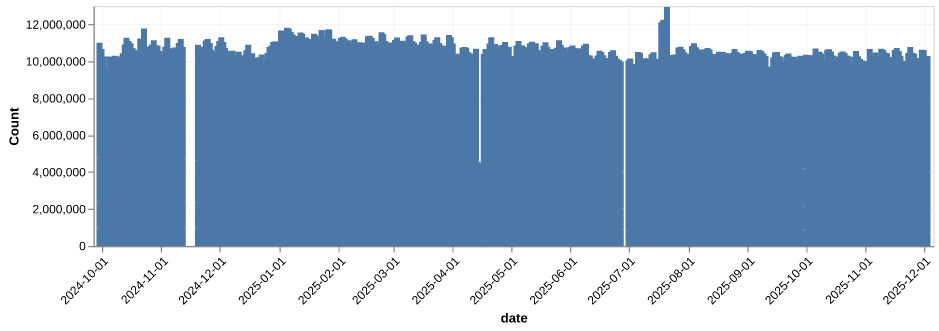

In [9]:
alt.Chart(daily_types_df).mark_bar().encode(
    x=alt.X('date:T', 
            axis=alt.Axis(labelAngle=-45, 
                         format='%Y-%m-%d')),  # Format as YYYY-MM-DD
    y=alt.Y('uniq_types:Q', title='Count'),
    tooltip=['date:T', 'uniq_types:Q']
).properties(
    width=700,
    height=200
).configure_axis(
    grid=True,
    gridOpacity=0.3
).save('chart.png', scale_factor=1.2)

Image('chart.png')

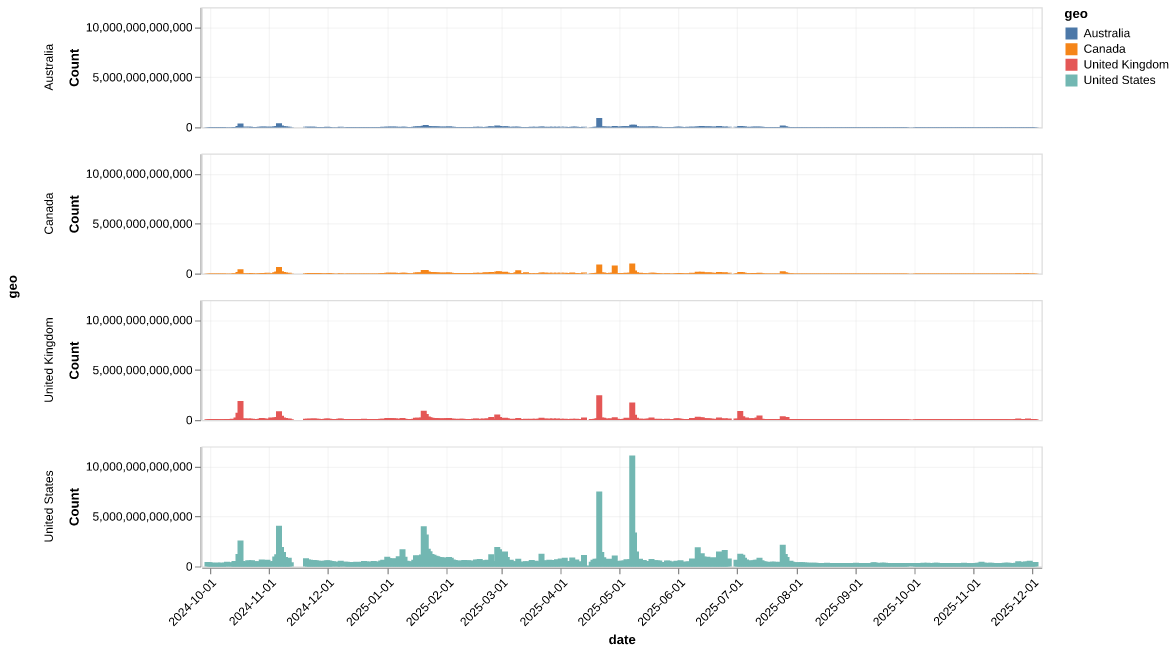

In [13]:
alt.Chart(daily_types_df).mark_bar().encode(
    x=alt.X('date:T', 
            axis=alt.Axis(labelAngle=-45, 
                         format='%Y-%m-%d')),  # Format as YYYY-MM-DD
    y=alt.Y('total_token:Q', title='Count'),
    row="geo",
    color="geo",
    tooltip=['date:T', 'total_token:Q']
).properties(
    width=700,
    height=100
).configure_axis(
    grid=True,
    gridOpacity=0.3
).save('chart.png', scale_factor=1.2)

Image('chart.png')

In [87]:
plan_html = conn.execute("""
EXPLAIN ANALYZE
SELECT
    geo,
    date,
    COUNT(*) AS uniq_types,
    SUM(counts) AS total_token
FROM wikilake.wikigrams
WHERE geo = 'United States'
  AND date BETWEEN '2025-01-01' AND '2026-01-01'
GROUP BY geo, date
ORDER BY geo, date;
""").fetchall()


for row in plan_html:
    print(row[1])

┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
 EXPLAIN ANALYZE SELECT     geo,     date,     COUNT(*) AS uniq_types,     SUM(counts) AS total_token FROM wikilake.wikigrams WHERE geo = 'United States'   AND date BETWEEN '2025-01-01' AND '2026-01-01' GROUP BY geo, date ORDER BY geo, date; 
┌────────────────────────────────────────────────┐
│┌──────────────────────────────────────────────┐│
││               Total Time: 3.87s              ││
│└──────────────────────────────────────────────┘│
└────────────────────────────────────────────────┘
┌───────────────────────────┐
│           QUERY           │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│      EXPLAIN_ANALYZE      │
│    ────────────────────   │
│           0 rows          │
│          (0.00s)          │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│ 

3.8s to do an AGGREGATED SUM on what used to be a large amount of data because of our hive partition. We only read what we need to read in this query. Now, what about the actual queries users would do:

In [13]:
plan_html = conn.execute("""
EXPLAIN ANALYZE
SELECT types, SUM(counts) as counts
FROM wikilake.wikigrams
WHERE geo = 'United States'
  AND date BETWEEN '2025-01-01' AND '2025-01-08'
GROUP BY types
LIMIT 10_000;
""").fetchall()

for row in plan_html:
    print(row[1])

┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
 EXPLAIN ANALYZE SELECT types, SUM(counts) as counts FROM wikilake.wikigrams WHERE geo = 'United States'   AND date BETWEEN '2025-01-01' AND '2025-01-08' GROUP BY types LIMIT 10_000; 
┌────────────────────────────────────────────────┐
│┌──────────────────────────────────────────────┐│
││              Total Time: 0.579s              ││
│└──────────────────────────────────────────────┘│
└────────────────────────────────────────────────┘
┌───────────────────────────┐
│           QUERY           │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│      EXPLAIN_ANALYZE      │
│    ────────────────────   │
│           0 rows          │
│          (0.00s)          │
└─────────────┬─────────────┘
┌─────────────┴─────────────┐
│      STREAMING_LIMIT      │
│    ────────────────────   │
│